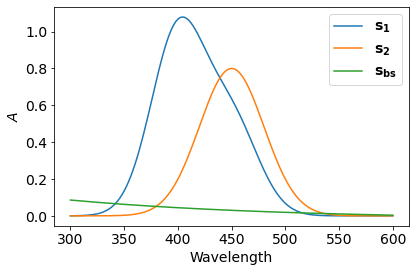

In [1]:
import numpy as np  # import numpy package (abbreviation stands for Numerical Python)
import matplotlib.pyplot as plt  # we plot graphs with this library
import matplotlib
from numba import njit, jit, vectorize, prange
import numba
from typing import Union
from scipy.integrate import odeint
from matplotlib import cm
import matplotlib as mpl
import math
from numpy.linalg import svd
from scipy.integrate import cumtrapz

plt.rcParams.update({'font.size': 14})

def plot_matrix(times: np.ndarray, wavelengths: np.ndarray, D: np.ndarray, zlim=(None, None),
               title='', cmap='hot_r'):
    
    zmin, zmax = zlim[0] if zlim[0] is not None else np.nanmin(D), zlim[1] if zlim[1] is not None else np.nanmax(D)
    
    x, y = np.meshgrid(wavelengths, times)  # needed for pcolormesh to correctly scale the image
    
    plt.pcolormesh(x, y, D, cmap=cmap, shading='auto', vmin=zmin, vmax=zmax)
    plt.colorbar(label='$\Delta A$')
    plt.xlabel('Wavelength $\\rightarrow$')
    plt.ylabel('$\\leftarrow$ Time ')
#     plt.gca().invert_yaxis()
#     plt.yscale('symlog', linthresh=1, linscale=1)
    plt.title(title)
#     plt.gca().yaxis.set_major_formatter(ScalarFormatter())
    plt.show()
    
def save_matrix(D, times, wavelengths, fname='output.txt', delimiter='\t', encoding='utf8'):
    # crop the data if necessary
    mat = np.vstack((wavelengths, D))
    buffer = delimiter + delimiter.join(f"{num}" for num in times) + '\n'
    buffer += '\n'.join(delimiter.join(f"{num}" for num in row) for row in mat.T)

    with open(fname, 'w', encoding=encoding) as f:
        f.write(buffer)

    
wavelengths = np.arange(300, 601, 2)
    
def gauss(x: Union[int, float, np.ndarray], mu: Union[int, float, np.ndarray], 
          sigma: Union[int, float, np.ndarray]) -> np.ndarray:
    return np.exp(-(x - mu) * (x - mu) / (2 * sigma * sigma))

S1 = gauss(wavelengths, 400, 25) + 0.5 * gauss(wavelengths, 450, 25)  # ground state bleach
S2 = 0.8 * gauss(wavelengths, 450, 30)  # excited state absorption band 1
Baseline = 0.05*np.exp(-0.005 * (wavelengths - 450)) - 0.02

S = np.vstack((S1, S2)).T
S_baseline = np.hstack((S, Baseline[:, None]))

# plot individual bands

plt.plot(wavelengths, S1, label='$\\mathbf{s_1}$')
plt.plot(wavelengths, S2, label='$\\mathbf{s_2}$')
plt.plot(wavelengths, Baseline, label='$\\mathbf{s_{bs}}$')

plt.xlabel('Wavelength')
plt.ylabel('$A$')
plt.tight_layout()
plt.legend()
# plt.savefig('species.svg', dpi=500)
plt.show()

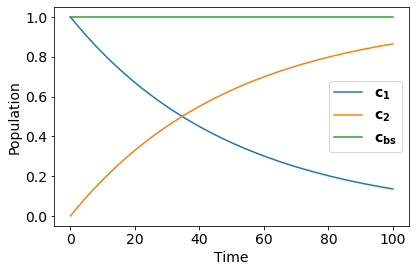

In [2]:
times = np.linspace(0, 100, 100)
k = 0.02
c = np.exp(-k * times)
C = np.vstack((c, 1-c)).T
C_swapped = np.vstack((1-c, c)).T
C_baseline = np.hstack((C, np.ones_like(times)[:, None]))

plt.plot(times, C_baseline[:, 0], label='$\\mathbf{c_1}$')
plt.plot(times, C_baseline[:, 1], label='$\\mathbf{c_2}$')
plt.plot(times, C_baseline[:, 2], label='$\\mathbf{c_{bs}}$')

plt.ylabel('Population')
plt.xlabel('Time')
plt.legend()
plt.tight_layout()

# plt.savefig('time_traces.svg', dpi=500)

plt.show()

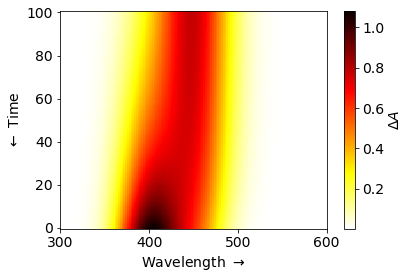

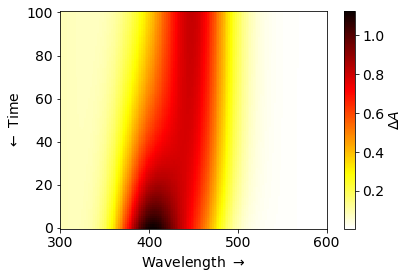

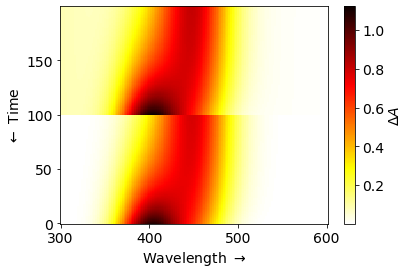

In [3]:
D = C @ S.T
D_baseline = C_baseline @ S_baseline.T

D_mix = np.vstack((D, D_baseline))
t_mix = np.arange(0, D_mix.shape[0], 1)

save_matrix(D, times, wavelengths, fname='D_test.txt')
save_matrix(D_baseline, times, wavelengths, fname='D_baseline_test.txt')

plot_matrix(times, wavelengths, D)
plot_matrix(times, wavelengths, D_baseline)
plot_matrix(t_mix, wavelengths, D_mix)


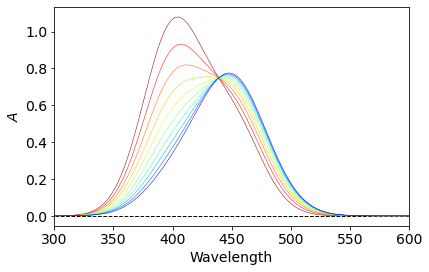

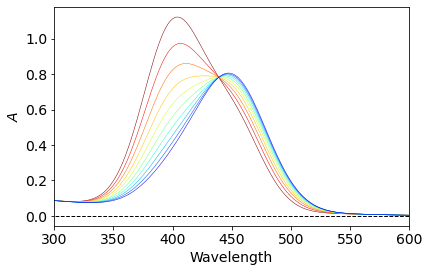

In [4]:
from matplotlib import cm

def plot_dataset(D, filepath=None, step=10):
    cmap = cm.get_cmap('jet_r')

    N = D.shape[0]
    for i in range(0, N, step):
        plt.plot(wavelengths, D[i], lw=0.5, color=cmap(i / N))

    plt.xlabel('Wavelength')
    plt.ylabel('$A$')
    plt.tight_layout()
    plt.xlim(wavelengths[0], wavelengths[-1])
    plt.hlines(0, 0, 1000, ls='--', color='k', lw=1)
    if filepath:
        plt.savefig(filepath, dpi=500)
    plt.show()
    
plot_dataset(D, filepath='Dataset1.svg')
plot_dataset(D_baseline, filepath='Dataset2.svg')

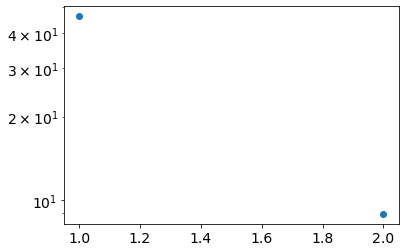

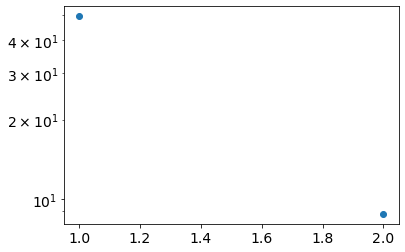

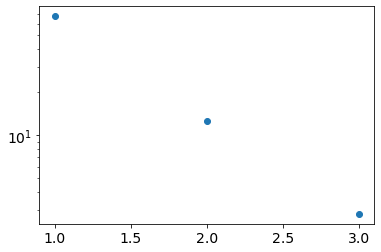

96.59023488171486

In [5]:
def get_svd_vectors(D, rcond=1e-10):
    U, S, VT = svd(D, full_matrices=False)
    cutoff = rcond * S.max()
    large = S > cutoff
    Sr = S[large]
    Ur = U[:, large]
    VrT = VT[large, :]
    
    return Sr, Ur, VrT

def plot_singular_vals(D, rcond=1e-10):
    Sr, Ur, VrT = get_svd_vectors(D, rcond)
    
    plt.scatter(np.arange(1, Sr.shape[0]+1,1), Sr)
    plt.yscale('log')
    plt.show()
    
    return Sr, Ur, VrT

def SVD_power(D, n_vals=2):
    U, S, VT = svd(D, full_matrices=False)
    return 100 * S[:n_vals].sum() / S.sum()
    
Sr, Ur, VrT = plot_singular_vals(D)
Srb, Urb, VrTb = plot_singular_vals(D_baseline)
Srm, Urm, VrTm = plot_singular_vals(D_mix)

SVD_power(D_mix)

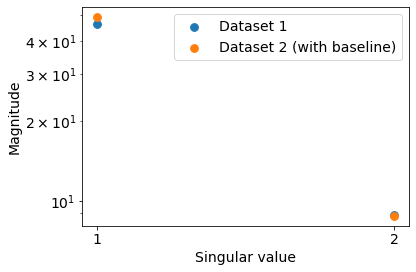

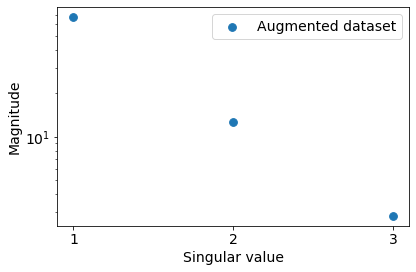

In [6]:
plt.scatter(np.arange(1, Sr.shape[0]+1,1), Sr, label='Dataset 1', s=60)
plt.scatter(np.arange(1, Srb.shape[0]+1,1), Srb, label='Dataset 2 (with baseline)', s=60)
plt.xlabel('Singular value')
plt.ylabel('Magnitude')
plt.xticks([1, 2])
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig('S_values.svg')
plt.show()

plt.scatter(np.arange(1, Srm.shape[0]+1,1), Srm, label='Augmented dataset', s=60)
plt.xlabel('Singular value')
plt.ylabel('Magnitude')
plt.xticks([1, 2, 3])
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig('S_values_mix.svg')
plt.show()

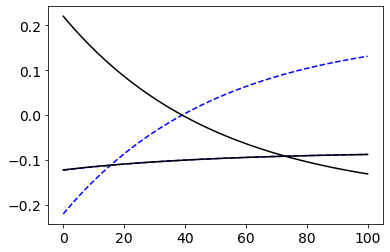

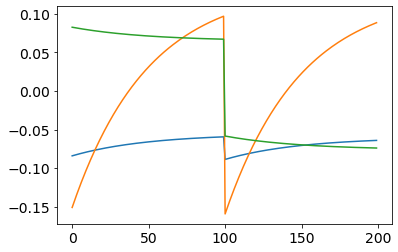

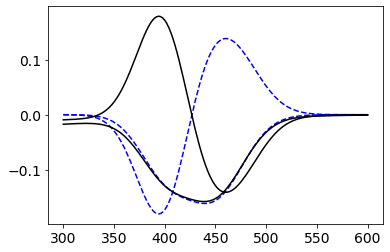

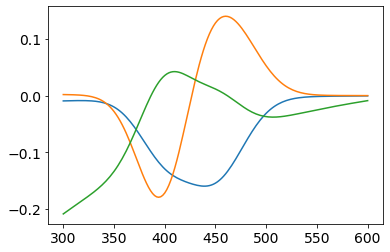

In [7]:
plt.plot(times, Ur, 'b', ls='--')
plt.plot(times, Urb, 'k')

plt.show()
plt.plot(t_mix, Urm)
plt.show()

plt.plot(wavelengths, VrT.T, 'b', ls='--')
plt.plot(wavelengths, VrTb.T, 'k')

plt.show()
plt.plot(wavelengths, VrTm.T)

plt.show()

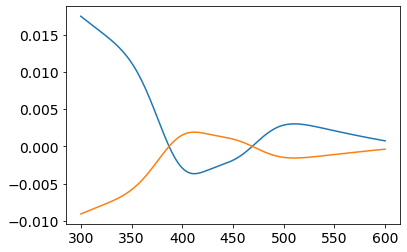

In [9]:
# VrTb_prime = VrTb #* np.asarray([-1, 0])[:, None]
# plt.plot(wavelengths, diff.T)

# plt.show()

# diff = VrTb.T @ VrT @ VrTb - VrT


C = VrTb @ VrT.T
CT = VrT @ VrTb.T

diff = VrT @ VrTb.T @ VrTb - VrT
diff = VrT @ (np.eye(VrT.shape[1]) - VrTb.T @ VrTb)


# VrT_est = CT @ VrTb
# VrT_est
# diff = VrT_est - VrT
# diff = (VrT.dot(VrTb.T) - 1).dot(VrT)

# plt.plot(wavelengths, VrT_est.T)
# plt.plot(wavelengths, VrT.T, 'k')
plt.plot(wavelengths, diff.T)

plt.show()



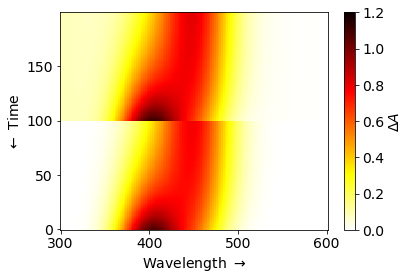

In [10]:
# D is correct, D_baseline is wrong, lets modify D_baseline to minimize the 3rd singular value and remove the baseline

def get_D_mix(D_subtr, D_baseline=D_baseline):
    D_baseline_modif = D_baseline - D_subtr
    return np.vstack((D,D_baseline_modif)), D_baseline_modif

_D_mix, D_baseline_modif = get_D_mix(0)
plot_matrix(t_mix, wavelengths, _D_mix, zlim=(0, 1.2))

vectors = []
# for i in range(18):
#     Sr, Ur, VrT = get_svd_vectors(_D_mix)
# #     print(Sr)
#     V_subtr = np.outer(Ur[:, -1], VrT[-1])[times.shape[0]:].mean(axis=0)
#     vectors.append(V_subtr)
# #     plt.plot(wavelengths, V_subtr)
# #     plt.show()
#     _D_mix, D_baseline_modif = get_D_mix(V_subtr, D_baseline_modif)
#     res = D - D_baseline_modif
#     ssq = (res ** 2).sum()
#     print(Sr, ssq)

# plot_matrix(t_mix, wavelengths, _D_mix, zlim=(0, 1.2))

# vectors = np.asarray(vectors)

# plt.plot(wavelengths, VrT.T)
# plt.show()

# _D_mix = get_D_mix(-0.5*VrT[-1])
# plot_matrix(t_mix, wavelengths, _D_mix, zlim=(0, 1.2))

# Sr, Ur, VrT = get_svd_vectors(_D_mix)
# plt.plot(wavelengths, VrT.T)
# plt.show()
# Sr

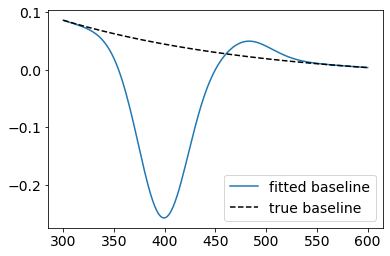

(array([73.06085019, 13.47546781]),
 array([-0.3120138 , -0.10510758, -0.3983712 ]))

In [14]:
# plt.plot(wavelengths, vectors.T)
# plt.show()

_D_mix, _ = get_D_mix(0*Baseline)
Sr, Ur, VrT = get_svd_vectors(_D_mix)
S1, U1, V1T = get_svd_vectors(D)
# plot_matrix(t_mix, wavelengths, _D_mix, zlim=(0, 1.2))

cb = VrT @ Baseline

C = VrT.dot(V1T.T)
V1T_est = C.T @ VrT

# plt.plot(wavelengths, V1T.T)
# # plt.plot(wavelengths, V1T_est.T)
# plt.show()

t = np.asarray([1, 1])

bl_ = (cb + t.dot(C.T)) @ VrT

plt.plot(wavelengths, bl_, label='fitted baseline')
plt.plot(wavelengths, Baseline, label='true baseline', ls='--', color='k')
plt.legend()
plt.show()

def get_S_of_mixD(D_subtr):
    _D_mix, _ = get_D_mix(D_subtr)
    Sr, _, _ = get_svd_vectors(_D_mix)
    return Sr

get_S_of_mixD(bl_), cb

In [34]:
from lmfit import Parameters, report_fit, Minimizer
from numpy.linalg import norm

params = Parameters()
params.add('t0', value=0, min=-10, max=10, vary=True)
params.add('t1', value=0, min=-10, max=10, vary=True)
params.add('t2', value=0, min=-10, max=10, vary=True)

S, U, VT = get_svd_vectors(D)
projector = VT.T.dot(VT) - np.eye(VT.shape[1])

def residuals(params):
    pars = [par.value for key, par in params.items()]
    cB = np.asarray(pars)
    
    bl_guess = cB.dot(VrT)
    
    A_prime = D_baseline - bl_guess
    Up, Sp, VpT = get_svd_vectors(A_prime)
    residuals = projector.dot(VpT.T)
    return residuals
    
#     _D_mix, _ = get_D_mix(bl_guess)
#     _Sr, _Ur, _VrT = get_svd_vectors(_D_mix)
#     _Sr[2:] = 0
#     D_svd_filtered = _Ur @ np.diag(_Sr) @ _VrT
#     curv_baseline = 1e5*np.gradient(np.gradient(bl_guess))# / norm(bl_guess)

#     return _Sr.sum() + norm(curv_baseline)
#     return norm(curv_baseline)
    
#     print(norm(curv_baseline))
    
#     return (D_svd_filtered - _D_mix) / norm(_D_mix)# + curv_baseline
    
#     return Sr.sum()
    
norm(residuals(params))

0.09456539749102041

In [35]:
minimizer = Minimizer(residuals, params, nan_policy='omit')

kwds = dict(jac='3-point', ftol=1e-10, xtol=1e-10, gtol= 1e-10, loss='linear', verbose=2)  
result = minimizer.minimize(method='least_squares', **kwds)  # minimize the residuals using TRF algorithm



   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.4713e-03                                    2.16e-01    
       1              2         5.1600e-05      4.42e-03       5.37e-01       2.08e-02    
       2              3         1.3935e-09      5.16e-05       6.80e-02       1.18e-04    
       3              4         9.7848e-18      1.39e-09       3.89e-04       9.90e-09    
       4              5         5.4962e-31      9.78e-18       3.27e-08       2.90e-16    
`gtol` termination condition is satisfied.
Function evaluations 5, initial cost 4.4713e-03, final cost 5.4962e-31, first-order optimality 2.90e-16.


name,value,standard error,relative error,initial value,min,max,vary
t0,0.32372406,4.8003e-07,(0.00%),0,-10.0000000,10.0000000,True
t1,-0.05583710,7.5009e-07,(0.00%),0,-10.0000000,10.0000000,True
t2,-0.42606013,1.8425e-08,(0.00%),0,-10.0000000,10.0000000,True


1.0484486317038279e-15


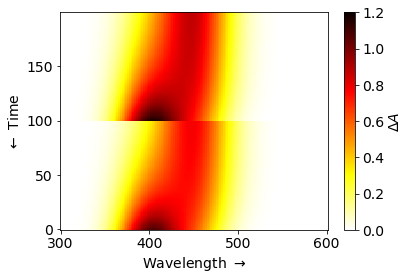

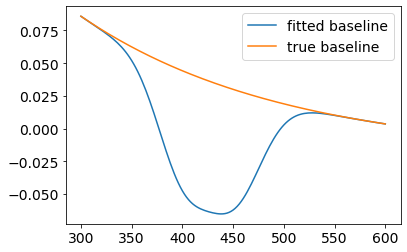

array([69.88881643, 12.56913932])

In [36]:
from IPython.display import display

display(result.params)

print(norm(residuals(result.params)))

coefs = np.asarray([par.value for key, par in result.params.items()])
bl_guess = coefs @ VrT
_D_mix, _ = get_D_mix(bl_guess)
sigma, _, _ = get_svd_vectors(_D_mix)

plot_matrix(t_mix, wavelengths, _D_mix, zlim=(0, 1.2))
plt.plot(wavelengths, bl_guess, label='fitted baseline')
plt.plot(wavelengths, Baseline, label='true baseline')
plt.legend()
plt.show()
sigma

# plt.plot(wavelengths, np.gradient(np.gradient(bl_guess)))
# plt.plot(wavelengths, np.gradient(np.gradient(Baseline)))

# plt.show()

# plt.plot(wavelengths, Baseline)

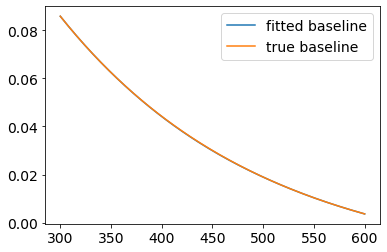

In [94]:
from scipy import sparse
t = np.asarray([-0.6, 0])
bl_hat = bl_guess + VT.T.dot(t)

L = bl_guess.shape[0]
diag1 = np.ones(L - 2)

DT1 = sparse.spdiags([diag1, -2*diag1, diag1], [0, -1, -2], L, L - 2)  # transposed D
H =  VT @ np.asarray(DT1.dot(DT1.T).todense())

b = H @ bl_guess
A = H @ VT.T

t = np.linalg.lstsq(A, b, rcond=None)[0]
bl_hat = bl_guess - VT.T.dot(t)

plt.plot(wavelengths, bl_hat, label='fitted baseline')
plt.plot(wavelengths, Baseline, label='true baseline')
plt.legend()
plt.show()

In [143]:
from lmfit import Parameters, report_fit, Minimizer

def alignment_correction(D_true, D_misaligned, max_sing_vals=5, verbose=2):
    params = Parameters()

    _, _, VT = get_svd_vectors(D_true)
    VT = VT[:max_sing_vals]
    
    _, _, VT_aug = get_svd_vectors(np.vstack((D_true, D_misaligned)))
    VT_aug = VT_aug[:max_sing_vals]
    
    for i in range(VT_aug.shape[0]):
        params.add(f't_{i}', value=0, min=-10, max=10, vary=True)
    
    VVT_p = VT.T.dot(VT)
    VVT_p.flat[::VVT_p.shape[0] + 1] -= 1  # calculate V @ V.T - I

    def residuals(params):
        pars = [par.value for key, par in params.items()]
        cB = np.asarray(pars)

        bl_guess = cB.dot(VT_aug)  # search baseline as linear combination of VT_aug

        D_mis_hat = D_misaligned - bl_guess
        _, _, VT_mis = get_svd_vectors(D_mis_hat)
        VT_mis = VT_mis[:max_sing_vals]
        residuals = VVT_p.dot(VT_mis.T)
        return residuals
    
    minimizer = Minimizer(residuals, params, nan_policy='omit')

    kwds = dict(jac='3-point', ftol=1e-8, xtol=1e-8, gtol= 1e-8, loss='linear', verbose=verbose)  
    result = minimizer.minimize(method='least_squares', **kwds)  # minimize the residuals using TRF algorithm
    
    pars = [par.value for key, par in result.params.items()]
    cB = np.asarray(pars)
#     print(cB)
    bl_guess = cB.dot(VT_aug)  # fitted baseline + some linear combination of VT vectors
    
    L = bl_guess.shape[0]
    diag1 = np.ones(L - 2)

    DT1 = sparse.spdiags([diag1, -2*diag1, diag1], [0, -1, -2], L, L - 2)  # transposed D
    H = VT.dot(np.asarray(DT1.dot(DT1.T).todense()))  # V.T @ D.T @ D

    b = H @ bl_guess
    A = H @ VT.T

    t = np.linalg.lstsq(A, b, rcond=None)[0]  # fitted coefficient that minimizes curvature on the baseline
#     print(t)
    
    bl_hat = bl_guess - VT.T.dot(t)  # fitted baseline
    
    return bl_hat, D_misaligned - bl_hat
    

    
bl, D_fixed = alignment_correction(D, D_baseline, max_sing_vals=10)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.4713e-03                                    2.16e-01    
       1              2         5.1600e-05      4.42e-03       5.37e-01       2.08e-02    
       2              3         1.3935e-09      5.16e-05       6.80e-02       1.18e-04    
       3              4         9.7848e-18      1.39e-09       3.89e-04       9.90e-09    
       4              5         5.4962e-31      9.78e-18       3.27e-08       2.90e-16    
`gtol` termination condition is satisfied.
Function evaluations 5, initial cost 4.4713e-03, final cost 5.4962e-31, first-order optimality 2.90e-16.


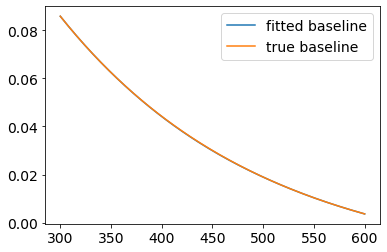

In [144]:
plt.plot(wavelengths, bl, label='fitted baseline')
plt.plot(wavelengths, Baseline, label='true baseline')
plt.legend()
plt.show()

In [186]:
path = r'C:\Users\dominik\Documents\RealTimeSync\Projects\2020-Bilirubin - 2nd half\UV-VIS\QY\Test 2ZE new setup'

data = np.genfromtxt(path + '/2Z 405 01.txt', delimiter='\t', filling_values=0)
D1 = data[1:, 1:].T
times = data[0, 1:]
wls1 = data[1:, 0]


data = np.genfromtxt(path + '/2E 405 01.txt', delimiter='\t', filling_values=0)
D2 = data[1:, 1:].T
times2 = data[0, 1:]
wls2 = data[1:, 0]



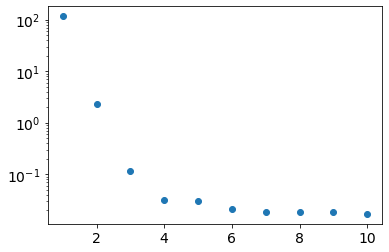

In [188]:
S, U, VT = get_svd_vectors(D2)
plt.scatter(np.arange(1, 11), S[:10])
plt.yscale('log')
plt.show()

In [190]:
bl, D_fixed = alignment_correction(D1, D2, max_sing_vals=4)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.9413e-01                                    2.15e-01    
       1              2         5.6927e-01      2.49e-02       2.51e+00       4.28e-02    
       2              3         5.6671e-01      2.56e-03       1.99e+00       1.95e-02    
       3              4         5.6652e-01      1.84e-04       3.60e-01       4.09e-03    
       4              5         5.6644e-01      8.08e-05       4.90e-01       6.17e-03    
       5              6         5.6641e-01      3.60e-05       2.77e-01       2.90e-03    
       6              7         5.6639e-01      1.76e-05       1.92e-01       2.62e-03    
       7              8         5.6638e-01      8.82e-06       1.36e-01       1.63e-03    
       8              9         5.6637e-01      4.50e-06       8.64e-02       1.29e-03    
       9             10         5.6637e-01      2.34e-06       5.92e-02       8.95e-04    

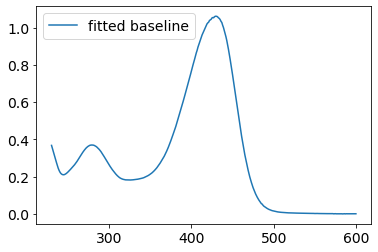

In [192]:
plt.plot(wls1, bl, label='fitted baseline')
plt.legend()
plt.show()

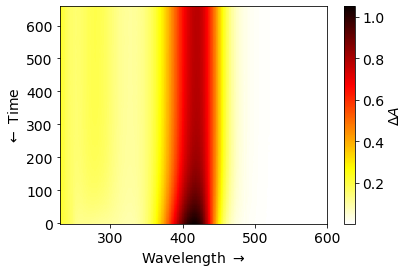

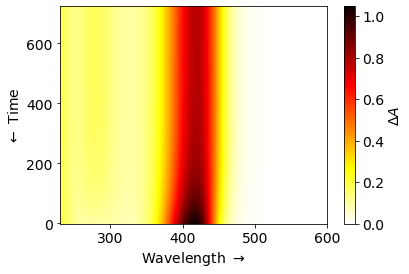

In [183]:
plot_matrix(times, wls1, D1)
plot_matrix(times2, wls1, D2)


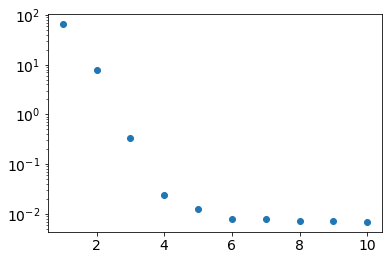

In [181]:
S, U, VT = get_svd_vectors(np.vstack((D1, D_fixed)))
plt.scatter(np.arange(1, 11), S[:10])
plt.yscale('log')
plt.show()